In [2]:
from functools import partial
from typing import Sequence, Tuple, Union

#import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as VisionF
#from lightning.pytorch.callbacks import Callback, ModelCheckpoint
from torch import Tensor
from torch.utils.data import DataLoader
#from torchmetrics.functional import accuracy
from torchvision.datasets import CIFAR10
from torchvision.models.resnet import resnet18
from torchvision.utils import make_grid

In [3]:
! pip install snntorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.6 MB/s eta 0:00:00


In [4]:
! pip install pytorch-metric-learning --pre


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.8 MB/s eta 0:00:00


In [5]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

<ipython-input-5-bd886847109b>:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [6]:
from pytorch_metric_learning.losses import NTXentLoss
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.regularizers import LpRegularizer
from pytorch_metric_learning import losses
from pytorch_metric_learning.losses import SelfSupervisedLoss


In [7]:
batch_size = 128
num_workers = 0  # to run notebook on CPU
#max_epochs = 200
#z_dim = 128

In [8]:
class BarlowTwinsTransform:
    def __init__(self, train=True, input_height=224, gaussian_blur=True, jitter_strength=1.0, normalize=None):
        self.input_height = input_height
        self.gaussian_blur = gaussian_blur
        self.jitter_strength = jitter_strength
        self.normalize = normalize
        self.train = train

        color_jitter = transforms.ColorJitter(
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.2 * self.jitter_strength,
        )

        color_transform = [transforms.RandomApply([color_jitter], p=0.8), transforms.RandomGrayscale(p=0.2)]

        if self.gaussian_blur:
            kernel_size = int(0.1 * self.input_height)
            if kernel_size % 2 == 0:
                kernel_size += 1

            color_transform.append(transforms.RandomApply([transforms.GaussianBlur(kernel_size=kernel_size)], p=0.5))

        self.color_transform = transforms.Compose(color_transform)

        if normalize is None:
            self.final_transform = transforms.ToTensor()
        else:
            self.final_transform = transforms.Compose([transforms.ToTensor(), normalize])

        self.transform = transforms.Compose(
            [
                transforms.RandomResizedCrop(self.input_height),
                transforms.RandomHorizontalFlip(p=0.5),
                self.color_transform,
                self.final_transform,
            ]
        )

        self.finetune_transform = None
        if self.train:
            self.finetune_transform = transforms.Compose(
                [
                    transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ]
            )
        else:
            self.finetune_transform = transforms.ToTensor()

    def __call__(self, sample):
        return self.transform(sample), self.transform(sample), self.finetune_transform(sample)

In [9]:
def cifar10_normalization():
    normalize = transforms.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]]
    )
    return normalize

In [10]:

train_transform = BarlowTwinsTransform(
    train=True, input_height=32, gaussian_blur=False, jitter_strength=0.5, normalize=cifar10_normalization()
)
train_dataset = CIFAR10(root=".", train=True, download=True, transform=train_transform)
train_set_1, train_set_2 = torch.utils.data.random_split(train_dataset, [49000, 1000])

val_transform = BarlowTwinsTransform(
    train=False, input_height=32, gaussian_blur=False, jitter_strength=0.5, normalize=cifar10_normalization()
)
val_dataset = CIFAR10(root=".", train=False, download=True, transform=train_transform)

train_loader_1 = DataLoader(train_set_1, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
train_loader_2 = DataLoader(train_set_2, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:01<00:00, 102757080.48it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [11]:
for batch in train_loader_1:
    (img1, img2, _), label = batch
    break

img_grid = make_grid(img1, normalize=True)
label.shape

torch.Size([128])

In [12]:

def show(imgs ):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VisionF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


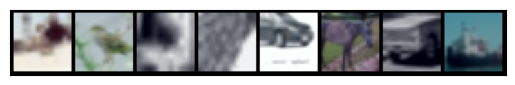

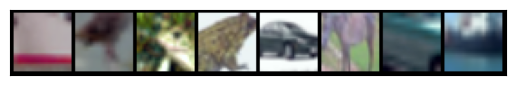

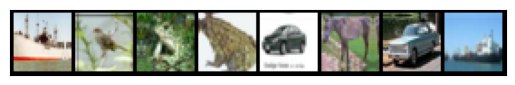

In [13]:
for i in [img1, img2, _] :
  img_grid = make_grid(i[:8], normalize=True)
  show(img_grid )
  print

In [14]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [15]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.9
num_steps = 20

In [26]:
net = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),

            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),

            #nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            #snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),

            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),

            #nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            #snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),

            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),

            nn.Linear(1024, 512),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
            ).to(device)



In [17]:
'''class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.lif1 = snn.Leaky(beta=beta)

        self.conv2 = nn.Conv2d(12, 64, 3, stride=1, padding=1)
        self.lif2 = snn.Leaky(beta=beta)

        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.lif3 = snn.Leaky(beta=beta)

        self.conv4 = nn.Conv2d(128, 256 *4, 3, stride=1, padding=1)
        self.lif4 = snn.Leaky(beta=beta)

        self.fc1 = nn.Linear(256 *4 , 128)
        self.lif5 = snn.Leaky(beta=beta)

        self.fc2 = nn.Linear(128, 64)
        self.lif6 = snn.Leaky(beta=beta)

    def forward(self, x):
        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()
        mem6 = self.lif6.init_leaky()

        # Record the final layer
        spk_rec = []
        mem_rec = []

        for step in range(num_steps):
            cur1 = F.max_pool2d(self.conv1(x), 2)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = F.max_pool2d(self.conv2(spk1), 2)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = F.max_pool2d(self.conv3(spk2), 2)
            spk3, mem3 = self.lif3(cur3, mem3)

            cur4 = F.max_pool2d(self.conv4(spk3), 2)
            spk4, mem4 = self.lif4(cur4, mem4)

            cur5 = spk4.view(spk4.size(0), -1)
            cur5 = self.fc1(cur5)
            spk5, mem5 = self.lif5(cur5, mem5)

            cur6 = self.fc2(spk5)
            spk6, mem6 = self.lif6(cur6, mem6)

            spk_rec.append(spk6)
            mem_rec.append(mem6)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)'''


'class Net(nn.Module):\n    def __init__(self):\n        super().__init__()\n\n        # Initialize layers\n        self.conv1 = nn.Conv2d(3, 12, 5)\n        self.lif1 = snn.Leaky(beta=beta)\n\n        self.conv2 = nn.Conv2d(12, 64, 3, stride=1, padding=1)\n        self.lif2 = snn.Leaky(beta=beta)\n\n        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)\n        self.lif3 = snn.Leaky(beta=beta)\n\n        self.conv4 = nn.Conv2d(128, 256 *4, 3, stride=1, padding=1)\n        self.lif4 = snn.Leaky(beta=beta)\n\n        self.fc1 = nn.Linear(256 *4 , 128)\n        self.lif5 = snn.Leaky(beta=beta)\n\n        self.fc2 = nn.Linear(128, 64)\n        self.lif6 = snn.Leaky(beta=beta)\n\n    def forward(self, x):\n        # Initialize hidden states and outputs at t=0\n        mem1 = self.lif1.init_leaky()\n        mem2 = self.lif2.init_leaky()\n        mem3 = self.lif3.init_leaky()\n        mem4 = self.lif4.init_leaky()\n        mem5 = self.lif5.init_leaky()\n        mem6 = self.lif6.ini

In [18]:
net


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Leaky()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Leaky()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): Leaky()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): Leaky()
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Linear(in_features=4096, out_features=1024, bias=True)
  (16): Leaky()
 

In [19]:
import torch
#torch.cuda.empty_cache()

In [20]:

'''(img1, img2, _), label = next(iter(train_loader_1))
data = img1.to(device)
targets = label.to(device)

spk_out, mem_out  = net(data)
spk_out.shape'''

'(img1, img2, _), label = next(iter(train_loader_1))\ndata = img1.to(device)\ntargets = label.to(device)\n\nspk_out, mem_out  = net(data)\nspk_out.shape'

In [25]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [45]:
#spk_rec, mem_rec = forward_pass(net, num_steps, data)


In [46]:
#spk_rec.shape

In [27]:
#loss

loss_func_self_trip = SelfSupervisedLoss(losses.TripletMarginLoss(distance = CosineSimilarity(),
                                        reducer = ThresholdReducer(high=0.3), embedding_regularizer = LpRegularizer()))
loss_func_NTX = NTXentLoss()
loss_func_self_NTX =  SelfSupervisedLoss(NTXentLoss())
loss_func_triplet = losses.TripletMarginLoss(distance = CosineSimilarity(),
                                    reducer = ThresholdReducer(high=0.3),
                                    embedding_regularizer = LpRegularizer())

loss_func_self_con = SelfSupervisedLoss(losses.ContrastiveLoss(pos_margin=0, neg_margin=1))

In [ ]:
loss_func_self_ang = SelfSupervisedLoss(losses.AngularLoss(alpha=40))


In [28]:
#optimizer

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))


In [29]:

num_epochs = 1

loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    print(epoch)
    # Training loop
    for (img1, img2, _), label in iter(train_loader_1):
        img1 = img1.to(device)
        img2 = img2.to(device)
        targets = label.to(device)

        # forward pass
        net.train()


        spk_rec_1, mem_rec_1 = forward_pass(net, num_steps, img1)
        spk_rec_2, mem_rec_2 = forward_pass(net, num_steps, img2)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        for step in range(num_steps):
            loss_val += loss_func_self_NTX(mem_rec_1[step], mem_rec_2[step])

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        counter += 1
        if counter%100 ==0 :
          print(counter)



0
100
200
300


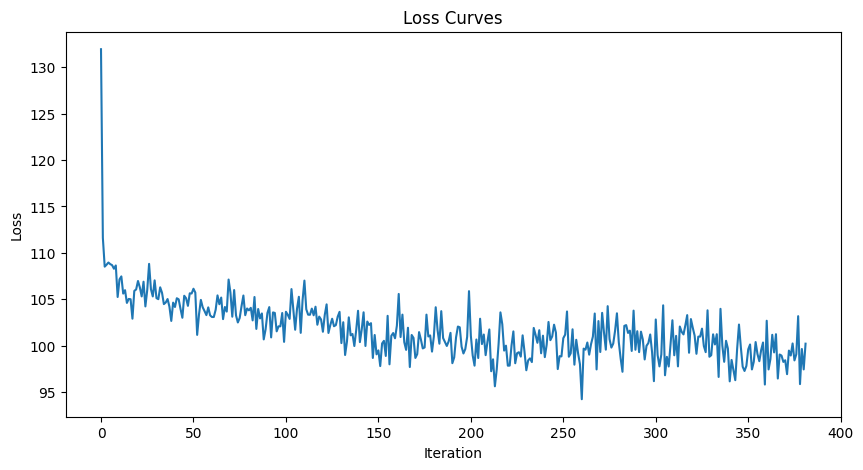

In [30]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.title("Loss Curves")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.show()

In [71]:

last_layer_weights =  net[-1].weight


AttributeError: ignored

In [31]:
l =[]
ll=[]
for (img1, img2, _), label in iter(val_loader) :
    test_data = _.to(device)
    target = label.to(device)
    l.append(test_data.detach().cpu().numpy())
    ll.append(target.detach().cpu().numpy())

In [32]:
ll=np.array(ll)
ll.shape

(78, 128)

In [33]:
ll = ll.reshape(78*128)
ll.shape

(9984,)

In [34]:
l=np.array(l)
l = l.reshape((78*128, 3, 32, 32))
l.shape

(9984, 3, 32, 32)

In [35]:
net.eval()
embeddings = []

with torch.no_grad():

            for (img1, img2, _), label in iter(val_loader) :
              test_data = _.to(device)
              test_targets = label.to(device)
              # Test set forward pass
              spk_out , mem_out = forward_pass(net, num_steps, test_data)
              embeddings.append(mem_out.sum(dim=0).detach().cpu().numpy())
            embeddings = np.array(embeddings)
            embeddings = embeddings.reshape((156 * 64, 512))

In [36]:
embeddings.shape

(9984, 512)

In [37]:

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize


In [53]:
n_neighbors = 5

num_examples = 3

In [54]:
X = embeddings
#mem_out.sum(dim=0).detach().cpu().numpy()

nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)

distances, indices = nbrs.kneighbors(X)


samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)


In [55]:
for i in range(len(samples_idx)):
  print(indices[samples_idx[i]])
  for j , k in enumerate(indices[samples_idx[i]]):
    print(np.transpose(l[k], (1, 2, 0)).shape)

[6334 6772  932 8553   34]
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
[8991 5216 8077 7531 5711]
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
[4570 9811 3197  115 7267]
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


In [51]:
#[3551 3429 8925 3483 8061]

SyntaxError: ignored

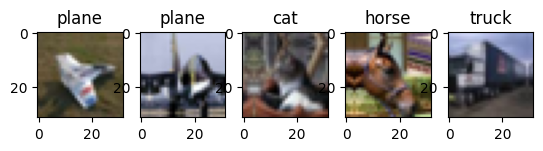

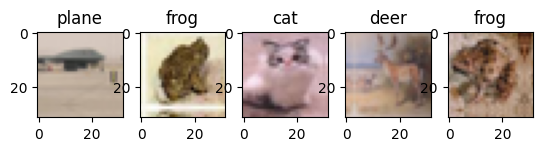

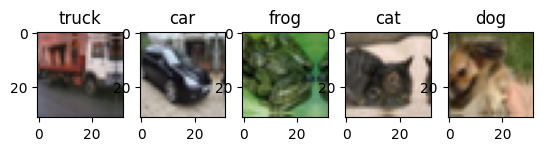

In [56]:
for i in range(len(samples_idx)):
    fig, ax = plt.subplots(1 , n_neighbors)
    #ax[0].imshow(np.transpose(test_data[samples_idx[i]].numpy(), (1, 2, 0)))
    #ax[0].set_title(classes[test_targets[samples_idx[i]]])
    for j , k in enumerate(indices[samples_idx[i]]):
      ax[j].imshow(np.transpose(l[k], (1, 2, 0)))
      ax[j].set_title(classes[ll[k]])


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [59]:
classifier = nn.Sequential(
            nn.Linear(512, 10),

            #nn.Linear(projection_dim, projection_dim, bias=False),
            #nn.BatchNorm1d(128)
        ).to(device)


In [60]:
def classifier_forward_pass(backbone , classifier_head , num_steps , data):
  final_tensor_rec = []
  #utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = backbone(data)
      final_tensor = classifier_head(mem_out)
      final_tensor_rec.append(final_tensor)

  return torch.stack(final_tensor_rec)

In [ ]:
'''(img1, img2, _), label = next(iter(train_loader_2))
data = img1.to(device)
targets = label.to(device)'''

In [ ]:
'''a =classifier_forward_pass(net , classifier , 20 , data)
a.shape'''

In [ ]:
'''#Define Network

class Classifier(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        # use the pretrained ResNet backbone
        self.backbone = backbone

        # freeze the backbone
        #for param in backbone.parameters():
           #param.requires_grad = False

        # create a linear layer for our downstream classification model
        self.fc = nn.Sequential(
            nn.Linear(512, 10, bias=False),

            #nn.Linear(projection_dim, projection_dim, bias=False),
            #nn.BatchNorm1d(128)
        )

    def forward(self, x):
        spk , mem = self.backbone(x)
        y_hat = self.fc(mem)
        return y_hat

# Load the network onto CUDA if available
classifier = Classifier(net).to(device)'''

In [ ]:
classifier

In [61]:
mse_loss = nn.MSELoss()
cosine_loss = torch.nn.CosineSimilarity(dim=0)
cross_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.005, betas=(0.9, 0.999))


In [66]:
num_epochs = 20
loss_hist = []
test_loss_hist = []
counter = 0
final_mem_rec = []
# Outer training loop
for epoch in range(num_epochs):
    print(epoch)
    iter_counter = 0
    train_batch = iter(train_loader_2)

    # Minibatch training loop
    for (img1, img2, _), label in train_batch:
        data = _.to(device)
        targets = label.to(device)

        # forward pass
        classifier.train()
        final_mem_rec = classifier_forward_pass(net , classifier , num_steps , data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1) , dtype=dtype, device=device)
        for step in range(num_steps):
          loss_val += cross_loss(final_mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            classifier.eval()
            (img1, img2, _), label = next(iter(val_loader))
            test_data = _.to(device)
            test_targets = label.to(device)

            # Test set forward pass
            final_test_mem = classifier_forward_pass(net , classifier , num_steps , test_data)
            #final_mem_rec.append(final_test_mem)
            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
              test_loss += cross_loss(final_test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            '''# Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1'''

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


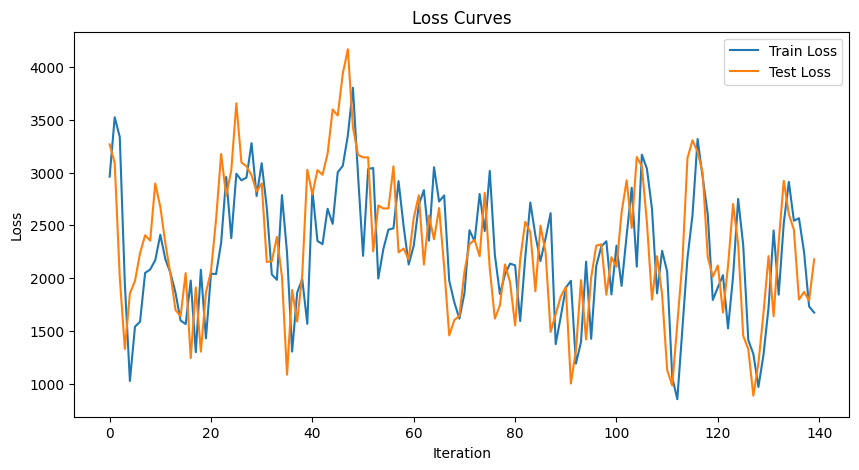

In [67]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [68]:
test_pred=final_test_mem.sum(dim=0).max(1)[1]
test_pred

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')

In [ ]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(test_targets.cpu(), test_pred.cpu())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()


In [ ]:
acc = np.mean((test_targets == test_pred).detach().cpu().numpy())
print(acc)